In [63]:
import lsst.daf.persistence as dafPersist
import matplotlib.pyplot as plt
import numpy as np

In [76]:
DATADIR="/renoir_data_02/jpreyes/lsst_data/CFHTLS_master/"
parameters_order = range(1,11)
butler = dafPersist.Butler(DATADIR+"/deepDiffTests/SpatialKernelOrders/deepDiffTest3") 

In [77]:
ccds = range(0,36)
totals = []
data_totals = []
for parameter in parameters_order:
    
    butler = dafPersist.Butler(DATADIR+"/deepDiffTests/SpatialKernelOrders/deepDiffTest"+str(parameter)) 
    no_data_ccds = 0
    total_diaSrcs = 0
    for ccd in ccds:
        if butler.datasetExists("deepDiff_diaSrc", {"ccd":ccd,"filter":'r', "visit":802227}):
            diaSrc = butler.get("deepDiff_diaSrc", {"ccd":ccd,"filter":'r', "visit":802227})
            total_diaSrcs+=len(diaSrc)
        else:
            no_data_ccds +=1
    
    totals.append(total_diaSrcs)
    data_totals.append(36-no_data_ccds)

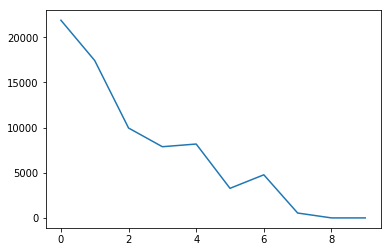

/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2016-04-04/lsstsw/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in divide


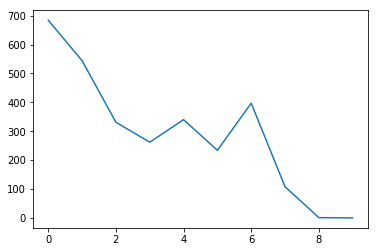

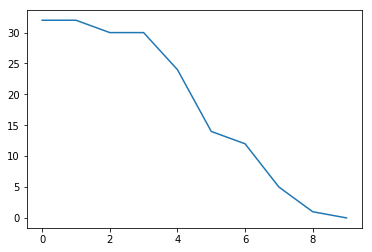

In [78]:
%matplotlib inline
plt.plot(totals)
plt.show()

plt.plot(np.divide(totals,data_totals))
plt.show()

plt.plot(data_totals)
plt.show()


In [98]:
parameters_order = range(50,550, 50)
ccds = range(0,36)
totals = []
data_totals = []
for parameter in parameters_order:
    
    butler = dafPersist.Butler(DATADIR+"/deepDiffTests/CellSizes/deepDiffTest"+str(parameter)) 
    no_data_ccds = 0
    total_diaSrcs = 0
    for ccd in ccds:
        if butler.datasetExists("deepDiff_diaSrc", {"ccd":ccd,"filter":'r', "visit":802227}):
            diaSrc = butler.get("deepDiff_diaSrc", {"ccd":ccd,"filter":'r', "visit":802227})
            total_diaSrcs+=len(diaSrc)
        else:
            no_data_ccds +=1
    
    totals.append(total_diaSrcs)
    data_totals.append(36-no_data_ccds)

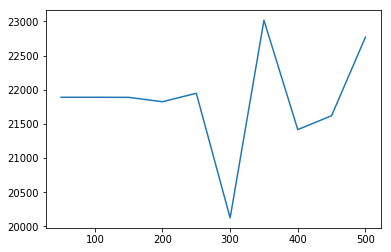

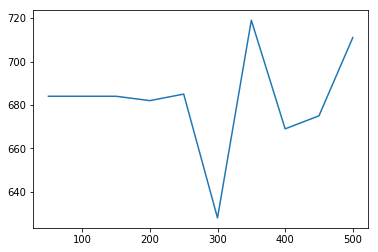

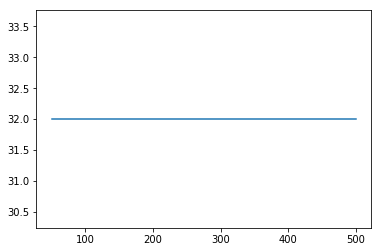

In [99]:
plt.plot(parameters_order,totals)
plt.show()

plt.plot(parameters_order, np.divide(totals,data_totals))
plt.show()

plt.plot(parameters_order, data_totals)
plt.show()


In [100]:
print totals

[21890, 21890, 21889, 21825, 21949, 20124, 23018, 21417, 21620, 22769]


In [101]:
parameters_order = range(11,33, 2)
ccds = range(0,36)
totals = []
data_totals = []
for parameter in parameters_order:
    
    butler = dafPersist.Butler(DATADIR+"/deepDiffTests/KernelSizes/deepDiffTest"+str(parameter)) 
    no_data_ccds = 0
    total_diaSrcs = 0
    for ccd in ccds:
        if butler.datasetExists("deepDiff_diaSrc", {"ccd":ccd,"filter":'r', "visit":802227}):
            diaSrc = butler.get("deepDiff_diaSrc", {"ccd":ccd,"filter":'r', "visit":802227})
            total_diaSrcs+=len(diaSrc)
        else:
            no_data_ccds +=1
    
    totals.append(total_diaSrcs)
    data_totals.append(36-no_data_ccds)

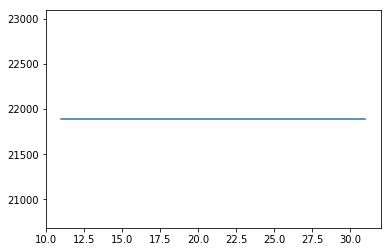

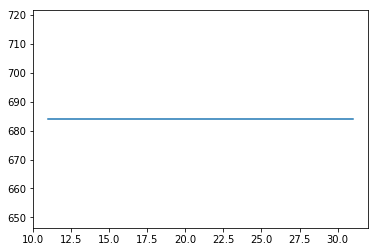

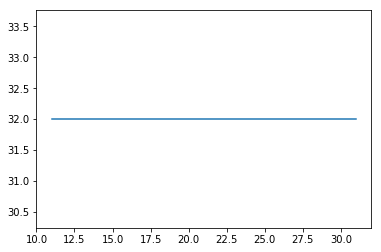

In [102]:
plt.plot(parameters_order,totals)
plt.show()

plt.plot(parameters_order, np.divide(totals,data_totals))
plt.show()

plt.plot(parameters_order, data_totals)
plt.show()

In [170]:
parameters_order = range(0,9, 1)
ccds = range(0,36)
totals = []
data_totals = []
for parameter in parameters_order:
    
    butler = dafPersist.Butler(DATADIR+"/deepDiffTests/DegGaussians/deepDiffTest"+str(parameter)) 
    no_data_ccds = 0
    total_diaSrcs = 0
    for ccd in ccds:
        if butler.datasetExists("deepDiff_diaSrc", {"ccd":ccd,"filter":'r', "visit":802227}):
            diaSrc = butler.get("deepDiff_diaSrc", {"ccd":ccd,"filter":'r', "visit":802227})
            total_diaSrcs+=len(diaSrc)
        else:
            no_data_ccds +=1
    
    totals.append(total_diaSrcs)
    data_totals.append(36-no_data_ccds)

In [171]:
parameters_order

[0, 1, 2, 3, 4, 5, 6, 7, 8]

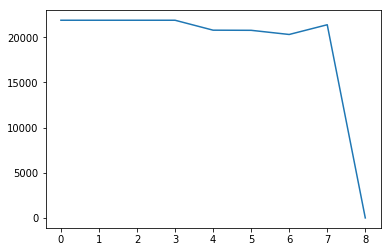

/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2016-04-04/lsstsw/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in divide


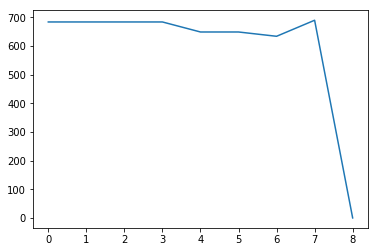

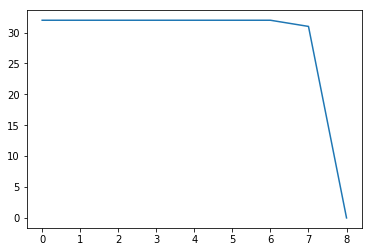

In [172]:
plt.plot(parameters_order,totals)
plt.show()

plt.plot(parameters_order, np.divide(totals,data_totals))
plt.show()

plt.plot(parameters_order, data_totals)
plt.show()

In [173]:
print totals

[21889, 21889, 21889, 21889, 20789, 20774, 20313, 21391, 0]


In [112]:
parameter = 3
butler = dafPersist.Butler(DATADIR+"/deepDiffTests/DegGaussians/deepDiffTest"+str(parameter)) 
no_data_ccds = 0
total_diaSrcs = 0
for ccd in ccds:
    if butler.datasetExists("deepDiff_diaSrc", {"ccd":ccd,"filter":'r', "visit":802227}):
        diaSrc = butler.get("deepDiff_diaSrc", {"ccd":ccd,"filter":'r', "visit":802227})
        total_diaSrcs+=len(diaSrc)
    else:
        no_data_ccds +=1

In [113]:
print total_diaSrcs

21889


In [196]:
parameters_order = range(0,4, 1)
ccds = range(0,36)
totals = []
data_totals = []
for parameter in parameters_order:
    
    butler = dafPersist.Butler(DATADIR+"/deepDiffTests/OptimalCombination/deepDiff"+str(parameter)) 
    no_data_ccds = 0
    total_diaSrcs = 0
    for ccd in ccds:
        if butler.datasetExists("deepDiff_diaSrc", {"ccd":ccd,"filter":'r', "visit":802227}):
            diaSrc = butler.get("deepDiff_diaSrc", {"ccd":ccd,"filter":'r', "visit":802227})
            total_diaSrcs+=len(diaSrc)
        else:
            print "no data for"+str(ccd)
            no_data_ccds +=1
    
    totals.append(total_diaSrcs)
    data_totals.append(36-no_data_ccds)

no data for0
no data for9
no data for18
no data for27
no data for0
no data for9
no data for18
no data for27
no data for0
no data for1
no data for9
no data for18
no data for27
no data for0
no data for1
no data for8
no data for9
no data for10
no data for18
no data for19
no data for27
no data for28


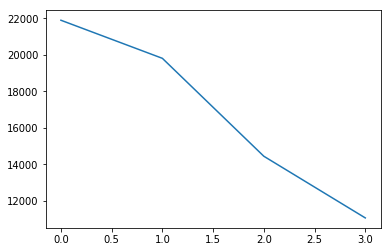

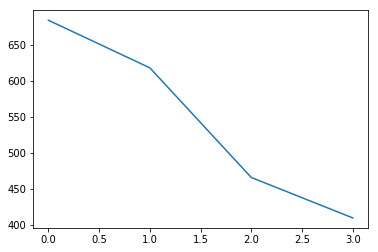

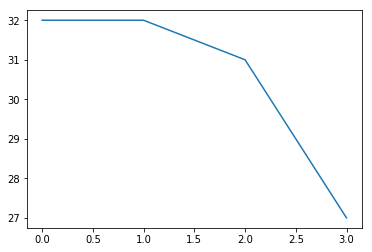

In [197]:

plt.plot(parameters_order,totals)
plt.show()

plt.plot(parameters_order, np.divide(totals,data_totals))
plt.show()

plt.plot(parameters_order, data_totals)
#plt.ylim(ymin=0, ymax=40)

plt.show()

In [191]:
print totals

[21889, 14451, 19806, 11078]
